In [1]:
# %% Import Libraries
#This is a test
import os
import pickle
import scipy.io
import numpy as np
import pandas as pd
import torch as tc
import matplotlib.pyplot as plt

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

import matplotlib.patches as mpatches
from tqdm import tqdm
from bptt.models import Model
import model_anafunctions as func

plt.rcParams['font.size'] = 20

c:\Users\cestarellas\anaconda3\envs\PLAna\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


ModuleNotFoundError: No module named 'bptt'

In [ ]:
#%% FUNCTIONS
def Hyper_mod(mpath,data_path):
    file=open(os.path.join(mpath,'hypers.pkl').replace("\\","/"),'rb')
    hyper=pickle.load(file)
    file.close()
    hyper['data_path']=os.path.join(data_path,'Training_data.npy').replace('\\','/')
    hyper['inputs_path']=os.path.join(data_path,'Training_inputs.npy').replace('\\','/')
    print(hyper['device_id'])
    hyper['device_id'] = 0
    print(hyper['device_id'])    
    full_name = open(os.path.join(mpath,'hypers.pkl').replace("\\","/"),"wb")                      # Name for training data
    pickle.dump(hyper,full_name)            # Save train data
    #close save instance 
    full_name.close()

In [ ]:
#%% Load Data and Behaviour
################################ Directories and files to modify ################################ 
# Select Path for multi-unit data
data_path = 'D:\\_work_cestarellas\\Analysis\\PLRNN\\noautoencoder\\neuralactivity\\OFC\\CE17_reduction\\datasets\\' 
#data_path = 'D:/_work_cestarellas/Analysis/PLRNN/noautoencoder/neuralactivity/OFC/CE17/L6/Test0/datasets/' 
# Select Path for Models (Folder containing the specific models to test)
model_path = 'D:\\_work_cestarellas\\Analysis\\PLRNN\\noautoencoder\\results\\OFC_red'
#model_path = 'D:/_work_cestarellas/Analysis/PLRNN/noautoencoder/results/Tuning_OFC_CE17_221008'
#meta information
Meta_file_path = "D:\\_work_cestarellas\\Analysis\\PLRNN\\noautoencoder\\neuralactivity\\OFC\\CE17_reduction\\datasets\\Metadata.pkl"
#Behaviour path
behaviour_path='D:/_work_cestarellas/Analysis/PLRNN/Session_Selected/OFC/CE17_L6'

# Loading models and simulations
model_name = 'CE14_L6_01_HU_40_l1_0.001_l2_08_l3_00_SL_400_encdim_14/001'
#model_name = 'CE1701_HU_256_l1_0.001_l2_08_l3_00_SL_400_encdim_65/001'

## Loading recorded neuronal activity (pre-processesed)
mpath=os.path.join(model_path,model_name).replace('\\','/')

train_n,train_i = func.load_data(data_path,'Training')
test_n,test_i = func.load_data(data_path,'Test')

Hyper_mod(mpath,data_path)

# Loading Model
num_epochs = 150000
m = Model()
m.init_from_model_path(mpath, epoch=num_epochs)
m.eval()

# Generation Training Data
ModelS=[]
for w_index in tqdm(range(len(train_n))):
    data_trial=tc.from_numpy(train_n[w_index]).float()          # tensor of neuronal data for initial trial data
    input_trial = tc.from_numpy(train_i[w_index]).float()
    length_sim = input_trial.shape[0]
    X, _ = m.generate_free_trajectory(data_trial,input_trial,length_sim,w_index)
    ModelS.append(X[:,:])

# Concatenating signals
Nseries,_=func.concatenate_list(train_n,0)          # recorded activity
Iseries,_=func.concatenate_list(train_i,0)          # external input
Mseries,_=func.concatenate_list(ModelS,0)           # simulated activity


0
0
Chosen model is clipped shPLRNN, the bases Parameter has no effect here!


100%|██████████| 55/55 [00:05<00:00,  9.26it/s]


In [5]:
#%% Classifier 1: Choice (Gamble or Safe)
# Identification of training trials in full behaviour (Tr_behaviour)

# Open the file in binary mode
with open(Meta_file_path, "rb") as f:
    # Load the pickled data
    Meta_info = pickle.load(f)

Test_trials = Meta_info["TestTrials"]; Training_trials = Meta_info["TrainingTrials"]    
    
itrain = 0
itest = 0
Trials_inmodel = []
for i in range(len(Meta_info["TestTrials"])+len(Meta_info["TrainingTrials"])):
    if i in Meta_info["TrainingTrials"]:
        Trials_inmodel.append(np.sum(np.diff(train_i[itrain][:,0])==1))
        itrain += 1
    elif i in Meta_info["TestTrials"]:
        Trials_inmodel.append(np.sum(np.diff(test_i[itest][:,0])==1))
        itest +=1
        
# Cumulative sum of the behavioural trials in concatenated trials        
CUM_trials = [np.sum(Trials_inmodel[:i]) for i in range(len(Trials_inmodel)+1)]

Ini_beh = [0]+[CUM_trials[i+1] for i in Test_trials]
End_beh = [CUM_trials[i] for i in Test_trials]+[CUM_trials[-1]]

Tr_behaviour = []
for k in range(len(Ini_beh)):
    Tr_behaviour= Tr_behaviour+[i for i in range(Ini_beh[k],End_beh[k])]


In [6]:
#%% Behaviour. Obtaining information to be classified.
# Info Columns BehData:
# 0- Trial Start
# 1- Trial End
# 2- Duration (Seconds)
# 3- Block
# 4- Gamble Arm (Right = 1, Left = 0)
# 5- Probability big Reward
# 6- Probability Small Reward
# 7- Ammount Big Reward
# 8- Ammount Small Reward
# 9- Number of previously wheel not stopping
# 10- Not responding Trial
# 11- Chosen Side (Right = 1, Left = 0)
# 12- Chosen Arm (Gamble = 1, Safe = 0)
# 13- Reward Given
# 14- Start of the trial (Sampling points)
# 15- Cue Presentation (Sampling Points)
# 16- Start of the response window (Sampling Points)
# 17- Reward Period (Sampling Points)
# 18- End of the trial

   # Pathway of the data (behaviour & Spike activity)

# Selection of the file
os.chdir(behaviour_path)
list_files = os.listdir(behaviour_path)
for i in list_files:
    if i.find('Behaviour')>0:
        Behaviour_name = i

# Load data
# Open the Behaviour file
Bdata = scipy.io.loadmat(Behaviour_name)
BehData = Bdata[list(Bdata.keys())[-1]]

# Classification of trials following the behabiour
GambleRewardTrials = np.where((BehData[:,12]==1) & (BehData[:,13]==1))[0]
GambleNoRewardTrials =  np.where((BehData[:,12]==1) & (BehData[:,13]==0))[0]
SafeRewardTrials = np.where((BehData[:,12]==0) & (BehData[:,13]==1))[0]
SafeNoRewardTrials = np.where((BehData[:,12]==0) & (BehData[:,13]==0))[0]
NoRespondingTrials = np.where(BehData[:,10]==1)[0]



In [7]:
# Classification of the Decision in the trials with previous information
# The previous information is the mean firing rate of each neuron from wheel stop up to reward

# Next Decision (G,S)
ND_se = (BehData[:,12]==1)*1+(BehData[:,12]==0)*0
ND = ND_se[Tr_behaviour]

# Firing Rate Neurons

# Temporal sectors
CueTime_end = np.where(np.diff(Iseries[:,0])==-1)[0]
StopTime = np.where(np.diff(Iseries[:,0])==1)[0]-49
# Data Set Mean Activity Zscore Neurons
num_trials = len(CueTime_end)
num_neurons = Nseries.shape[1]
X_data = np.zeros((num_trials,num_neurons))
X_model = np.zeros((num_trials,num_neurons))
for it in range(num_trials):
    X_data[it,:]=np.mean(Nseries[StopTime[it]:CueTime_end[it],:],0)
    X_model[it,:]=np.mean(Mseries[StopTime[it]:CueTime_end[it],:],0)
    

#%% Next Decisions
score_data=[]
score_model=[]
score_modelSh=[]
score_dataSh=[]

clf = LinearDiscriminantAnalysis()
for i in range(1000):
    list_trials=np.linspace(0,X_data.shape[0]-1,X_data.shape[0]).astype(int)
    np.random.shuffle(list_trials)
    # Classifying data
    X=X_data[list_trials,:]
    y=ND[list_trials]
    random_state=0
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=0
        )
    clf.fit(X_train,y_train)
    score_data.append(clf.score(X_test,y_test))

    # Classifying model
    Xm=X_model[list_trials,:]
    random_state=0
    X_trainM, X_testM, y_trainM, y_testM = train_test_split(
        Xm, y, test_size=0.2, stratify=y, random_state=0
        )
    random_state=0
    clf.fit(X_trainM,y_trainM)
    score_model.append(clf.score(X_testM,y_testM))
    
    # Classifying data Shuffle
    list_trials=np.linspace(0,X_data.shape[0]-1,X_data.shape[0]).astype(int)
    y=ND[list_trials]
    random_state=0
    X_trainS, X_testS, y_trainS, y_testS = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=0
        )

    clf.fit(X_trainS,y_trainS)
    score_dataSh.append(clf.score(X_testS,y_testS))
    # Classifying model Shuffle
    X_trainMS, X_testMS, y_trainMS, y_testMS = train_test_split(
        Xm, y, test_size=0.2, stratify=y, random_state=0
        )
    clf.fit(X_trainMS,y_trainMS)
    score_modelSh.append(clf.score(X_testMS,y_testMS))


fig, ax = plt.subplots()
Models = ['Data', 'Shuffle','Model','Shuffle']
ax.boxplot([score_data,score_dataSh,score_model,score_modelSh],labels=Models)
ax.set_ylabel('Test Score')
ax.set_title('Choice (Gamble-Safe)')
plt.show()

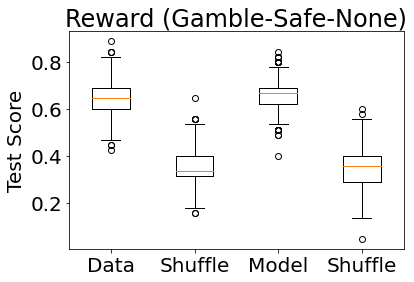

In [7]:
# Classification of the Type of Reward in the trials with information during reward and ITI period
# The previous information is the mean firing rate of each neuron from Reward until the initial point of the following trial

# Reward (Gamble, Safe, Nothing)
RW_se = (BehData[:,12]==1)*(BehData[:,13])*2+(BehData[:,13])*(BehData[:,12]==0)*1
RW = RW_se[Tr_behaviour]

# Firing Rate Neurons

# Temporal sectors
RewTime_ini = np.where(np.diff(Iseries[:,0])==-1)[0]
RT_end = np.where(np.diff(Iseries[:,0])==1)[0]-49
RewTime_end = np.append(RT_end[1:],Iseries.shape[0])

# Data Set Mean Activity Zscore Neurons
num_trials = len(RewTime_end)
num_neurons = Nseries.shape[1]
X_data = np.zeros((num_trials,num_neurons))
X_model = np.zeros((num_trials,num_neurons))
for it in range(num_trials):
    X_data[it,:]=np.mean(Nseries[RewTime_ini[it]:RewTime_end[it],:],0)
    X_model[it,:]=np.mean(Mseries[RewTime_ini[it]:RewTime_end[it],:],0)
    

#%% Reward Identification
score_data=[]
score_model=[]
score_modelSh=[]
score_dataSh=[]

clf = LinearDiscriminantAnalysis()
for i in range(1000):
    list_trials=np.linspace(0,X_data.shape[0]-1,X_data.shape[0]).astype(int)
    np.random.shuffle(list_trials)
    # Classifying data
    X=X_data[list_trials,:]
    y=RW[list_trials]
    random_state=0
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=0
        )
    clf.fit(X_train,y_train)
    score_data.append(clf.score(X_test,y_test))

    # Classifying model
    Xm=X_model[list_trials,:]
    random_state=0
    X_trainM, X_testM, y_trainM, y_testM = train_test_split(
        Xm, y, test_size=0.2, stratify=y, random_state=0
        )
    random_state=0
    clf.fit(X_trainM,y_trainM)
    score_model.append(clf.score(X_testM,y_testM))
    
    # Classifying data Shuffle
    list_trials=np.linspace(0,X_data.shape[0]-1,X_data.shape[0]).astype(int)
    y=RW[list_trials]
    random_state=0
    X_trainS, X_testS, y_trainS, y_testS = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=0
        )

    clf.fit(X_trainS,y_trainS)
    score_dataSh.append(clf.score(X_testS,y_testS))
    # Classifying model Shuffle
    X_trainMS, X_testMS, y_trainMS, y_testMS = train_test_split(
        Xm, y, test_size=0.2, stratify=y, random_state=0
        )
    clf.fit(X_trainMS,y_trainMS)
    score_modelSh.append(clf.score(X_testMS,y_testMS))


fig, ax = plt.subplots()
Models = ['Data', 'Shuffle','Model','Shuffle']
ax.boxplot([score_data,score_dataSh,score_model,score_modelSh],labels=Models)
ax.set_ylabel('Test Score')
ax.set_title('Reward (Gamble-Safe-None)')
plt.show()

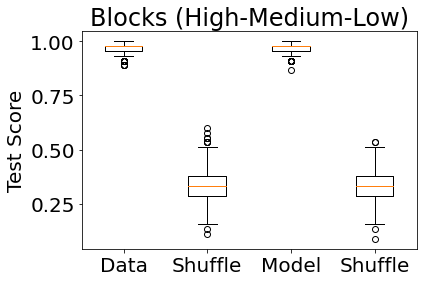

In [8]:
# Classification of the Type of Reward in the trials with information during reward and ITI period
# The previous information is the mean firing rate of each neuron from Reward until the initial point of the following trial

# Blocks (High, Medium, Low)
blocks=np.unique(BehData[:,5])
if len(blocks)==3:
    B_se=(BehData[:,5]==blocks[0])*0+(BehData[:,5]==blocks[1])*1+(BehData[:,5]==blocks[2])*2
elif len(blocks)==2:
    B_se=(BehData[:,5]==blocks[0])*0+(BehData[:,5]==blocks[1])*1
elif len(blocks)<2:
    print("There is no different blocks to classify the data")
else:
    print("This is not the original task")
BI = B_se[Tr_behaviour]

# Firing Rate Neurons

# Temporal sectors
TrialTime_ini = np.where(np.diff(Iseries[:,0])==1)[0]-49
TrialTime_end = np.append(TrialTime_ini[1:],Iseries.shape[0])

# Data Set Mean Activity Zscore Neurons
num_trials = len(TrialTime_end)
num_neurons = Nseries.shape[1]
X_data = np.zeros((num_trials,num_neurons))
X_model = np.zeros((num_trials,num_neurons))
for it in range(num_trials):
    X_data[it,:]=np.mean(Nseries[TrialTime_ini[it]:TrialTime_end[it],:],0)
    X_model[it,:]=np.mean(Mseries[TrialTime_ini[it]:TrialTime_end[it],:],0)
    

#%% Reward Identification
score_data=[]
score_model=[]
score_modelSh=[]
score_dataSh=[]

clf = LinearDiscriminantAnalysis()
for i in range(1000):
    list_trials=np.linspace(0,X_data.shape[0]-1,X_data.shape[0]).astype(int)
    np.random.shuffle(list_trials)
    # Classifying data
    X=X_data[list_trials,:]
    y=BI[list_trials]
    random_state=0
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=0
        )
    clf.fit(X_train,y_train)
    score_data.append(clf.score(X_test,y_test))

    # Classifying model
    Xm=X_model[list_trials,:]
    random_state=0
    X_trainM, X_testM, y_trainM, y_testM = train_test_split(
        Xm, y, test_size=0.2, stratify=y, random_state=0
        )
    random_state=0
    clf.fit(X_trainM,y_trainM)
    score_model.append(clf.score(X_testM,y_testM))
    
    # Classifying data Shuffle
    list_trials=np.linspace(0,X_data.shape[0]-1,X_data.shape[0]).astype(int)
    y=BI[list_trials]
    random_state=0
    X_trainS, X_testS, y_trainS, y_testS = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=0
        )

    clf.fit(X_trainS,y_trainS)
    score_dataSh.append(clf.score(X_testS,y_testS))
    # Classifying model Shuffle
    X_trainMS, X_testMS, y_trainMS, y_testMS = train_test_split(
        Xm, y, test_size=0.2, stratify=y, random_state=0
        )
    clf.fit(X_trainMS,y_trainMS)
    score_modelSh.append(clf.score(X_testMS,y_testMS))


fig, ax = plt.subplots()
Models = ['Data', 'Shuffle','Model','Shuffle']
ax.boxplot([score_data,score_dataSh,score_model,score_modelSh],labels=Models)
ax.set_ylabel('Test Score')
ax.set_title('Blocks (High-Medium-Low)')
plt.show()